In [1]:
import numpy as np 
import torch
import os 
import re
import matplotlib.pyplot as plt
import spectrogram
from Models.models import get_timestep_embedding
from DDPM import DDPM_Scheduler
from scipy.io import wavfile
from IPython.display import Audio
import audio_dataloader
import torchaudio
import yaml
from AudioLDM_Models.variational_autoencoder.modules import Encoder, Decoder
from torch.utils.data import DataLoader
## Play the audio
from IPython.display import Audio

/home/pidud/miniconda3/envs/audioldm_train/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VAE_config = yaml.load(open('checkpoints/16k_64.yaml', 'r'), Loader=yaml.FullLoader)

In [3]:
## Load Autoencoder from weights 
from AudioLDM_Models.variational_autoencoder.autoencoder import AutoencoderKL
VAE_config = yaml.load(open('checkpoints/16k_64.yaml', 'r'), Loader=yaml.FullLoader)
Autoencoder = AutoencoderKL(**VAE_config['model']['params'])
state_dict = torch.load('checkpoints/vae_mel_16k_64bins.ckpt')['state_dict']
state_dict = {k: v for k, v in state_dict.items() if not re.match('loss', k)}
Autoencoder.load_state_dict(state_dict)

Removing weight norm...


<All keys matched successfully>

In [4]:
target_sample_rate = 16000

In [5]:
data_path = 'data/'
loader = audio_dataloader.AudioDataset(data_path, 160*200 * 44100//target_sample_rate, target_sample_rate,'cpu')
dataloader = DataLoader(loader, batch_size=2, shuffle=True)
test_data = next(iter(dataloader))

In [6]:
## Encode the data
posteriror = Autoencoder.encode(test_data)
latent = posteriror.sample()

In [15]:
latent.shape

torch.Size([2, 8, 50, 16])

In [7]:
## Decode the data
reconstructed = Autoencoder.decode(latent)

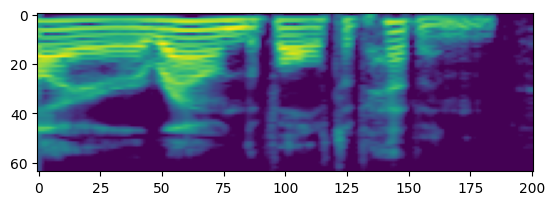

In [8]:
plt.imshow((test_data.swapaxes(2,3).squeeze()[0].numpy()))

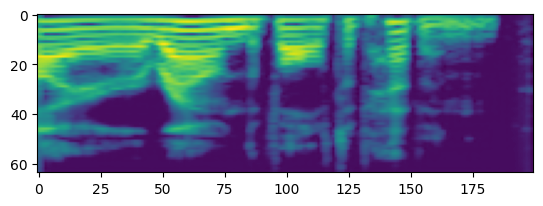

In [9]:
plt.imshow(reconstructed.swapaxes(2,3).squeeze()[0].detach().numpy())

In [10]:
audio = Autoencoder.decode_to_waveform(reconstructed).squeeze().detach().numpy()
Audio(audio, rate=16000)

In [11]:
spec_rec = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=64, sample_rate=target_sample_rate)(torch.exp(reconstructed.swapaxes(2,3)).detach())
g_lim_audio = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=1024, hop_length=160, n_iter=10)(spec_rec).squeeze().detach().numpy()

In [12]:

Audio(g_lim_audio, rate=target_sample_rate)

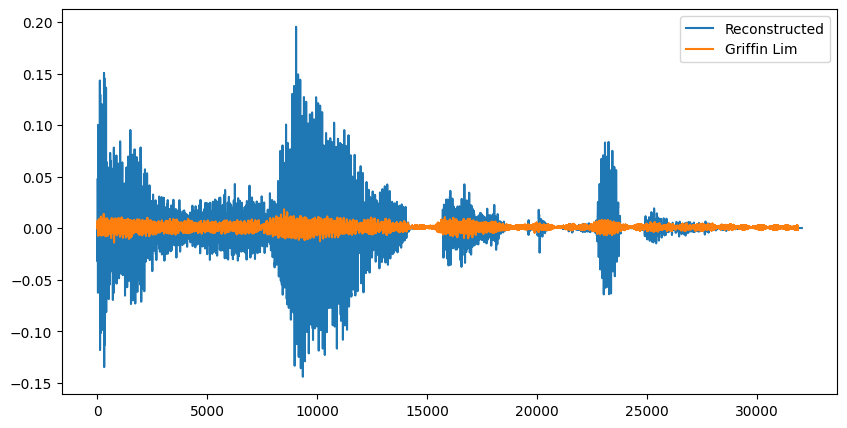

In [13]:
## plot the waveform
## PLot the two waveforms right next to eachother
fig = plt.figure(figsize=(10, 5))
plt.plot(audio[0], label='Reconstructed')
plt.plot(g_lim_audio[0], label='Griffin Lim')
plt.legend()
plt.show()
